# Recommender System for player simmilarity for transfers

In [1]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import cosine_similarity
import warnings
warnings.filterwarnings('ignore')

sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 8)

## Transfer Season 2025 - Find Similar Players for Recruitment

In [2]:
player_stats = pd.read_csv('data/player_stats.csv')

# basic eda
def clean_percentage(col):
    if col.dtype == 'object':
        return col.str.rstrip('%').astype(float) / 100
    return col

player_stats['kast_num'] = clean_percentage(player_stats['kast'])
player_stats['hs_percent_num'] = clean_percentage(player_stats['hs_percent'])
player_stats['cl_percent_num'] = clean_percentage(player_stats['cl_percent'])

print(f" Loaded {len(player_stats)} players")

 Loaded 81 players


In [4]:
# find duelists

DUELIST_AGENTS = ['Jett', 'Raze', 'Reyna', 'Phoenix', 'Yoru', 'Neon', 'Iso']

def is_duelist(agents_str):
    """Check if player primarily plays duelist agents"""
    if pd.isna(agents_str):
        return False
    agents_str = agents_str.lower()
    duelist_count = sum(1 for agent in DUELIST_AGENTS if agent.lower() in agents_str)
    return duelist_count >= 1  # At least 1 duelist agent

player_stats['is_duelist'] = player_stats['agents'].apply(is_duelist)
duelists = player_stats[player_stats['is_duelist']].copy()

print(f"✓ Found {len(duelists)} duelist players")
print(f"  Teams represented: {duelists['team'].nunique()}")


✓ Found 27 duelist players
  Teams represented: 16


## Feature Engineering with Weights for simmilarity calculation


In [5]:
FEATURE_CONFIG = {
    'combat': {
        'features': ['acs', 'adr', 'kd_ratio', 'kpr'],
        'weight': 0.35,
        'description': 'Raw fragging power'
    },
    'aggression': {
        'features': ['fkpr', 'fdpr'],
        'weight': 0.30,
        'description': 'Entry/engagement style'
    },
    'precision': {
        'features': ['hs_percent_num'],
        'weight': 0.15,
        'description': 'Mechanical skill'
    },
    'consistency': {
        'features': ['kast_num', 'cl_percent_num'],
        'weight': 0.20,
        'description': 'Reliability under pressure'
    }
}

In [7]:
print("\nFeature Weights Configuration:")

for category, config in FEATURE_CONFIG.items():
    print ('\n')
    print(f"  {category.upper()} ({config['weight']*100:.0f}%): {config['description']}")
    print(f"    Features: {', '.join(config['features'])}")



Feature Weights Configuration:


  COMBAT (35%): Raw fragging power
    Features: acs, adr, kd_ratio, kpr


  AGGRESSION (30%): Entry/engagement style
    Features: fkpr, fdpr


  PRECISION (15%): Mechanical skill
    Features: hs_percent_num


  CONSISTENCY (20%): Reliability under pressure
    Features: kast_num, cl_percent_num


In [9]:
# collect and combine all features

all_features = []
for config in FEATURE_CONFIG.values():
    all_features.extend(config['features'])

# Create feature matrix
feature_matrix = duelists[all_features].copy()

# Handle any missing values
feature_matrix = feature_matrix.fillna(feature_matrix.mean())

print(f"\n Using {len(all_features)} features across 4 categories")
print(f" Feature matrix shape: {feature_matrix.shape}")


 Using 9 features across 4 categories
 Feature matrix shape: (27, 9)


## Normalizing and Applying weights

In [11]:
scaler = StandardScaler()
features_normalized = scaler.fit_transform(feature_matrix)
features_normalized_df = pd.DataFrame(features_normalized, 
                                     columns=all_features,
                                     index=feature_matrix.index)

# Apply category weights
weighted_features = []
feature_names_weighted = []

for category, config in FEATURE_CONFIG.items():
    category_features = config['features']
    weight = config['weight']
    
    for feature in category_features:
        weighted_col = features_normalized_df[feature] * weight
        weighted_features.append(weighted_col)
        feature_names_weighted.append(f"{feature}_weighted")

# Combine into weighted feature matrix
weighted_feature_matrix = pd.DataFrame(
    np.column_stack(weighted_features),
    columns=feature_names_weighted,
    index=feature_matrix.index
)

print(weighted_feature_matrix.head())

    acs_weighted  adr_weighted  kd_ratio_weighted  kpr_weighted  \
0       0.846181      0.751533           1.248754      0.985526   
3       0.268266      0.316218           0.322812      0.340715   
7       0.156034      0.137427           0.262425      0.211753   
11      0.434103      0.518328          -0.019384      0.340715   
12      0.172785      0.129654           0.282554      0.168765   

    fkpr_weighted  fdpr_weighted  hs_percent_num_weighted  kast_num_weighted  \
0        0.364931      -0.453063                -0.094089           0.453585   
3        0.436331      -0.040725                 0.114712           0.094705   
7        0.079333      -0.040725                -0.128890           0.139565   
11       0.436331      -0.178171                 0.045111           0.453585   
12      -0.349065      -0.246894                 0.114712           0.184425   

    cl_percent_num_weighted  
0                 -0.110126  
3                 -0.047307  
7                 -0.00542

## Building the Recommender System

In [12]:
# Calculate similarity matrix

# Calculate similarity matrix
similarity_matrix = cosine_similarity(weighted_feature_matrix)
similarity_df = pd.DataFrame(
    similarity_matrix,
    index=duelists['player_name'],
    columns=duelists['player_name']
)

print(f"✓ Computed similarity matrix ({similarity_matrix.shape})")

✓ Computed similarity matrix ((27, 27))


In [13]:
def recommend_similar_duelists (player_name, top_n = 5, exclude_same_team = True):

    
    """
    Find top N most similar duelists to the given player
    
    Parameters:
    -----------
    player_name : str
        Name of the player to find similar players for
    top_n : int
        Number of recommendations to return
    exclude_same_team : bool
        Whether to exclude teammates from recommendations
    
    Returns:
    --------
    DataFrame with recommended players and similarity scores
    """

    if player_name not in similarity_df.index:
        available = similarity_df.index.tolist()
        raise ValueError(f"Player '{player_name}' not found. Available: {available[:10]}...")
    
    # Get similarity scores
    similarities = similarity_df[player_name].sort_values(ascending=False)
    
    # Remove the player themselves
    similarities = similarities[similarities.index != player_name]
    
    # Optionally exclude same team
    if exclude_same_team:
        player_team = duelists[duelists['player_name'] == player_name]['team'].values[0]
        different_team_mask = duelists.set_index('player_name').loc[similarities.index, 'team'] != player_team
        similarities = similarities[different_team_mask]
    
    # Get top N
    top_similar = similarities.head(top_n)
    
    # Create results dataframe
    results = []
    for similar_player, similarity_score in top_similar.items():
        player_data = duelists[duelists['player_name'] == similar_player].iloc[0]
        results.append({
            'player_name': similar_player,
            'team': player_data['team'],
            'similarity': similarity_score * 100,
            'acs': player_data['acs'],
            'kd_ratio': player_data['kd_ratio'],
            'kpr': player_data['kpr'],
            'fkpr': player_data['fkpr'],
            'fdpr': player_data['fdpr'],
            'hs_percent': player_data['hs_percent_num'],
            'kast': player_data['kast_num'],
            'agents': player_data['agents']
        })
    
    return pd.DataFrame(results)


In [14]:
# visualization function

def visualize_comparison(original_player, recommendations):
    """Create comprehensive visualization comparing player to recommendations"""
    
    # Get original player data
    orig_data = duelists[duelists['player_name'] == original_player].iloc[0]
    
    fig = plt.figure(figsize=(18, 12))
    gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)
    
    # Title
    fig.suptitle(f'Duelist Similarity Analysis: {original_player} ({orig_data["team"]})\n'
                 f'Transfer Season Recommendations - Similar Playing Styles',
                 fontsize=16, fontweight='bold', y=0.98)
    
    # ===== 1. Similarity Scores (Top Left) =====
    ax1 = fig.add_subplot(gs[0, 0])
    colors = plt.cm.RdYlGn(recommendations['similarity'] / 100)
    bars = ax1.barh(recommendations['player_name'], recommendations['similarity'], color=colors, edgecolor='black')
    ax1.set_xlabel('Similarity Score (%)', fontweight='bold')
    ax1.set_title('Top 5 Most Similar Duelists', fontweight='bold', pad=10)
    ax1.set_xlim(0, 100)
    ax1.grid(axis='x', alpha=0.3)
    
    for i, (bar, val) in enumerate(zip(bars, recommendations['similarity'])):
        ax1.text(val + 1, bar.get_y() + bar.get_height()/2, f'{val:.1f}%', 
                va='center', fontsize=9, fontweight='bold')
    
    # ===== 2. Radar Chart (Top Center & Right) =====
    ax2 = fig.add_subplot(gs[0, 1:], projection='polar')
    
    # Radar metrics
    radar_metrics = ['ACS', 'K/D', 'KPR', 'FKPR', 'HS%', 'KAST']
    
    # Normalize to 0-1 scale for radar
    def normalize_for_radar(val, min_val, max_val):
        return (val - min_val) / (max_val - min_val) if max_val > min_val else 0.5
    
    # Original player values
    orig_values = [
        normalize_for_radar(orig_data['acs'], duelists['acs'].min(), duelists['acs'].max()),
        normalize_for_radar(orig_data['kd_ratio'], duelists['kd_ratio'].min(), duelists['kd_ratio'].max()),
        normalize_for_radar(orig_data['kpr'], duelists['kpr'].min(), duelists['kpr'].max()),
        normalize_for_radar(orig_data['fkpr'], duelists['fkpr'].min(), duelists['fkpr'].max()),
        normalize_for_radar(orig_data['hs_percent_num'], duelists['hs_percent_num'].min(), duelists['hs_percent_num'].max()),
        normalize_for_radar(orig_data['kast_num'], duelists['kast_num'].min(), duelists['kast_num'].max())
    ]
    
    angles = np.linspace(0, 2 * np.pi, len(radar_metrics), endpoint=False).tolist()
    orig_values += orig_values[:1]
    angles += angles[:1]
    
    # Plot original player
    ax2.plot(angles, orig_values, 'o-', linewidth=2, label=original_player, color='red')
    ax2.fill(angles, orig_values, alpha=0.15, color='red')
    
    # Plot top 3 similar players
    colors_radar = ['blue', 'green', 'orange']
    for idx, (_, row) in enumerate(recommendations.head(3).iterrows()):
        rec_values = [
            normalize_for_radar(row['acs'], duelists['acs'].min(), duelists['acs'].max()),
            normalize_for_radar(row['kd_ratio'], duelists['kd_ratio'].min(), duelists['kd_ratio'].max()),
            normalize_for_radar(row['kpr'], duelists['kpr'].min(), duelists['kpr'].max()),
            normalize_for_radar(row['fkpr'], duelists['fkpr'].min(), duelists['fkpr'].max()),
            normalize_for_radar(row['hs_percent'], duelists['hs_percent_num'].min(), duelists['hs_percent_num'].max()),
            normalize_for_radar(row['kast'], duelists['kast_num'].min(), duelists['kast_num'].max())
        ]
        rec_values += rec_values[:1]
        ax2.plot(angles, rec_values, 'o-', linewidth=1.5, label=row['player_name'], 
                color=colors_radar[idx], alpha=0.7)
        ax2.fill(angles, rec_values, alpha=0.05, color=colors_radar[idx])
    
    ax2.set_xticks(angles[:-1])
    ax2.set_xticklabels(radar_metrics, size=10)
    ax2.set_ylim(0, 1)
    ax2.set_title('Performance Profile Comparison', fontweight='bold', pad=20, size=12)
    ax2.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1), fontsize=9)
    ax2.grid(True)
    
    # ===== 3. Combat Stats Comparison (Middle Left) =====
    ax3 = fig.add_subplot(gs[1, 0])
    combat_metrics = ['acs', 'kd_ratio', 'kpr']
    x_pos = np.arange(len(combat_metrics))
    width = 0.15
    
    # Original player
    orig_combat = [orig_data['acs'], orig_data['kd_ratio'], orig_data['kpr']]
    
    # Normalize for comparison
    normalized_orig = []
    for metric, val in zip(combat_metrics, orig_combat):
        norm_val = normalize_for_radar(val, duelists[metric].min(), duelists[metric].max())
        normalized_orig.append(norm_val)
    
    ax3.bar(x_pos, normalized_orig, width, label=original_player, color='red', alpha=0.7, edgecolor='black')
    
    # Top 3 recommendations
    for i, (_, row) in enumerate(recommendations.head(3).iterrows()):
        normalized_rec = []
        for metric in combat_metrics:
            norm_val = normalize_for_radar(row[metric], duelists[metric].min(), duelists[metric].max())
            normalized_rec.append(norm_val)
        ax3.bar(x_pos + (i+1)*width, normalized_rec, width, 
               label=row['player_name'], color=colors_radar[i], alpha=0.7, edgecolor='black')
    
    ax3.set_ylabel('Normalized Score', fontweight='bold')
    ax3.set_title('Combat Performance (Normalized)', fontweight='bold', pad=10)
    ax3.set_xticks(x_pos + width * 1.5)
    ax3.set_xticklabels(['ACS', 'K/D', 'KPR'])
    ax3.legend(fontsize=8)
    ax3.grid(axis='y', alpha=0.3)
    
    # ===== 4. Aggression Profile (Middle Center) =====
    ax4 = fig.add_subplot(gs[1, 1])
    
    # Scatter plot: FKPR vs FDPR
    ax4.scatter(recommendations['fkpr'], recommendations['fdpr'], 
               s=recommendations['similarity']*3, alpha=0.6, 
               c=range(len(recommendations)), cmap='viridis', edgecolors='black', linewidth=1.5)
    
    # Original player
    ax4.scatter(orig_data['fkpr'], orig_data['fdpr'], s=300, color='red', 
               marker='*', edgecolors='black', linewidth=2, label=original_player, zorder=10)
    
    # Diagonal line (balanced aggression)
    max_val = max(recommendations['fkpr'].max(), recommendations['fdpr'].max(), 
                  orig_data['fkpr'], orig_data['fdpr'])
    ax4.plot([0, max_val], [0, max_val], 'r--', alpha=0.5, linewidth=2, label='Balanced')
    
    # Annotate
    for _, row in recommendations.iterrows():
        ax4.annotate(row['player_name'], (row['fkpr'], row['fdpr']), 
                    xytext=(5, 5), textcoords='offset points', fontsize=8, alpha=0.7)
    
    ax4.set_xlabel('First Kills per Round (FKPR)', fontweight='bold')
    ax4.set_ylabel('First Deaths per Round (FDPR)', fontweight='bold')
    ax4.set_title('Aggression Profile: Entry vs Risk', fontweight='bold', pad=10)
    ax4.legend(fontsize=8)
    ax4.grid(alpha=0.3)
    
    # ===== 5. Stat Breakdown Table (Middle Right) =====
    ax5 = fig.add_subplot(gs[1, 2])
    ax5.axis('tight')
    ax5.axis('off')
    
    # Create comparison table
    table_data = []
    table_data.append(['Player', 'Team', 'ACS', 'K/D', 'FKPR', 'HS%'])
    
    # Original player (bold)
    table_data.append([
        f'★ {original_player}',
        orig_data['team'],
        f"{orig_data['acs']:.1f}",
        f"{orig_data['kd_ratio']:.2f}",
        f"{orig_data['fkpr']:.2f}",
        f"{orig_data['hs_percent_num']*100:.0f}%"
    ])
    
    # Recommendations
    for _, row in recommendations.iterrows():
        table_data.append([
            row['player_name'],
            row['team'],
            f"{row['acs']:.1f}",
            f"{row['kd_ratio']:.2f}",
            f"{row['fkpr']:.2f}",
            f"{row['hs_percent']*100:.0f}%"
        ])
    
    table = ax5.table(cellText=table_data, cellLoc='left', loc='center',
                     colWidths=[0.25, 0.15, 0.15, 0.15, 0.15, 0.15])
    table.auto_set_font_size(False)
    table.set_fontsize(9)
    table.scale(1, 2)
    
    # Style header
    for i in range(6):
        table[(0, i)].set_facecolor('#4CAF50')
        table[(0, i)].set_text_props(weight='bold', color='white')
    
    # Style original player row
    for i in range(6):
        table[(1, i)].set_facecolor('#FFE5E5')
        table[(1, i)].set_text_props(weight='bold')
    
    ax5.set_title('Stat Comparison Table', fontweight='bold', pad=10)
    
    # ===== 6. Feature Importance (Bottom Left) =====
    ax6 = fig.add_subplot(gs[2, 0])
    
    categories = list(FEATURE_CONFIG.keys())
    weights = [FEATURE_CONFIG[cat]['weight'] * 100 for cat in categories]
    colors_cat = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#FFA07A']
    
    bars = ax6.barh(categories, weights, color=colors_cat, edgecolor='black', linewidth=1.5)
    ax6.set_xlabel('Weight (%)', fontweight='bold')
    ax6.set_title('Feature Category Weights Used', fontweight='bold', pad=10)
    ax6.set_xlim(0, 40)
    ax6.grid(axis='x', alpha=0.3)
    
    for bar, val in zip(bars, weights):
        ax6.text(val + 1, bar.get_y() + bar.get_height()/2, f'{val:.0f}%', 
                va='center', fontsize=10, fontweight='bold')
    
    # ===== 7. Agent Overlap (Bottom Center) =====
    ax7 = fig.add_subplot(gs[2, 1])
    ax7.axis('off')
    
    # Agent analysis
    orig_agents = set([a.strip().strip("'[]") for a in orig_data['agents'].split(',')])
    
    agent_text = f"★ {original_player}'s Agents:\n"
    agent_text += f"   {', '.join(list(orig_agents)[:4])}\n\n"
    agent_text += "Agent Pool Overlap:\n"
    agent_text += "-" * 30 + "\n"
    
    for _, row in recommendations.head(3).iterrows():
        rec_agents = set([a.strip().strip("'[]") for a in str(row['agents']).split(',')])
        overlap = orig_agents.intersection(rec_agents)
        overlap_pct = (len(overlap) / len(orig_agents)) * 100 if len(orig_agents) > 0 else 0
        agent_text += f"\n{row['player_name']}:\n"
        agent_text += f"  Shared: {', '.join(list(overlap)[:3])}\n"
        agent_text += f"  Overlap: {overlap_pct:.0f}%\n"
    
    ax7.text(0.05, 0.95, agent_text, transform=ax7.transAxes, fontsize=10,
            verticalalignment='top', fontfamily='monospace',
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.3))
    ax7.set_title('Agent Pool Analysis', fontweight='bold', pad=10)
    
    # ===== 8. Recommendation Summary (Bottom Right) =====
    ax8 = fig.add_subplot(gs[2, 2])
    ax8.axis('off')
    
    summary_text = "🎯 RECRUITMENT INSIGHTS\n"
    summary_text += "=" * 30 + "\n\n"
    
    top_rec = recommendations.iloc[0]
    summary_text += f"TOP RECOMMENDATION:\n"
    summary_text += f"  {top_rec['player_name']} ({top_rec['team']})\n"
    summary_text += f"  Similarity: {top_rec['similarity']:.1f}%\n\n"
    
    summary_text += "WHY SIMILAR:\n"
    
    # Compare key stats
    if abs(top_rec['fkpr'] - orig_data['fkpr']) < 0.03:
        summary_text += f"  ✓ Similar aggression\n"
    if abs(top_rec['kd_ratio'] - orig_data['kd_ratio']) < 0.2:
        summary_text += f"  ✓ Comparable K/D\n"
    if abs(top_rec['acs'] - orig_data['acs']) < 30:
        summary_text += f"  ✓ Similar impact (ACS)\n"
    
    summary_text += f"\nDIVERSITY:\n"
    summary_text += f"  {recommendations['team'].nunique()} different teams\n"
    summary_text += f"  Avg similarity: {recommendations['similarity'].mean():.1f}%\n"
    
    ax8.text(0.05, 0.95, summary_text, transform=ax8.transAxes, fontsize=10,
            verticalalignment='top', fontfamily='monospace',
            bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.3))
    ax8.set_title('Executive Summary', fontweight='bold', pad=10)
    
    plt.savefig(f'recommendation_{original_player.replace(" ", "_")}.png', 
                dpi=300, bbox_inches='tight')
    print(f"\n✓ Saved visualization: recommendation_{original_player.replace(' ', '_')}.png")
    
    return fig



 Top 5 Similar Duelists (excluding MIBR teammates):

player_name team  similarity   acs  kd_ratio  fkpr
  something  PRX   95.435361 220.4      1.17  0.16
     kaajak  FNC   86.916369 227.1      1.20  0.21
   SpiritZ1  DRG   70.836846 237.0      1.03  0.21
    jawgemo   G2   69.014176 230.4      1.09  0.20
  Flashback  DRX   66.715511 223.1      1.12  0.17

  comprehensive comparison visualization...

✓ Saved visualization: recommendation_aspas.png


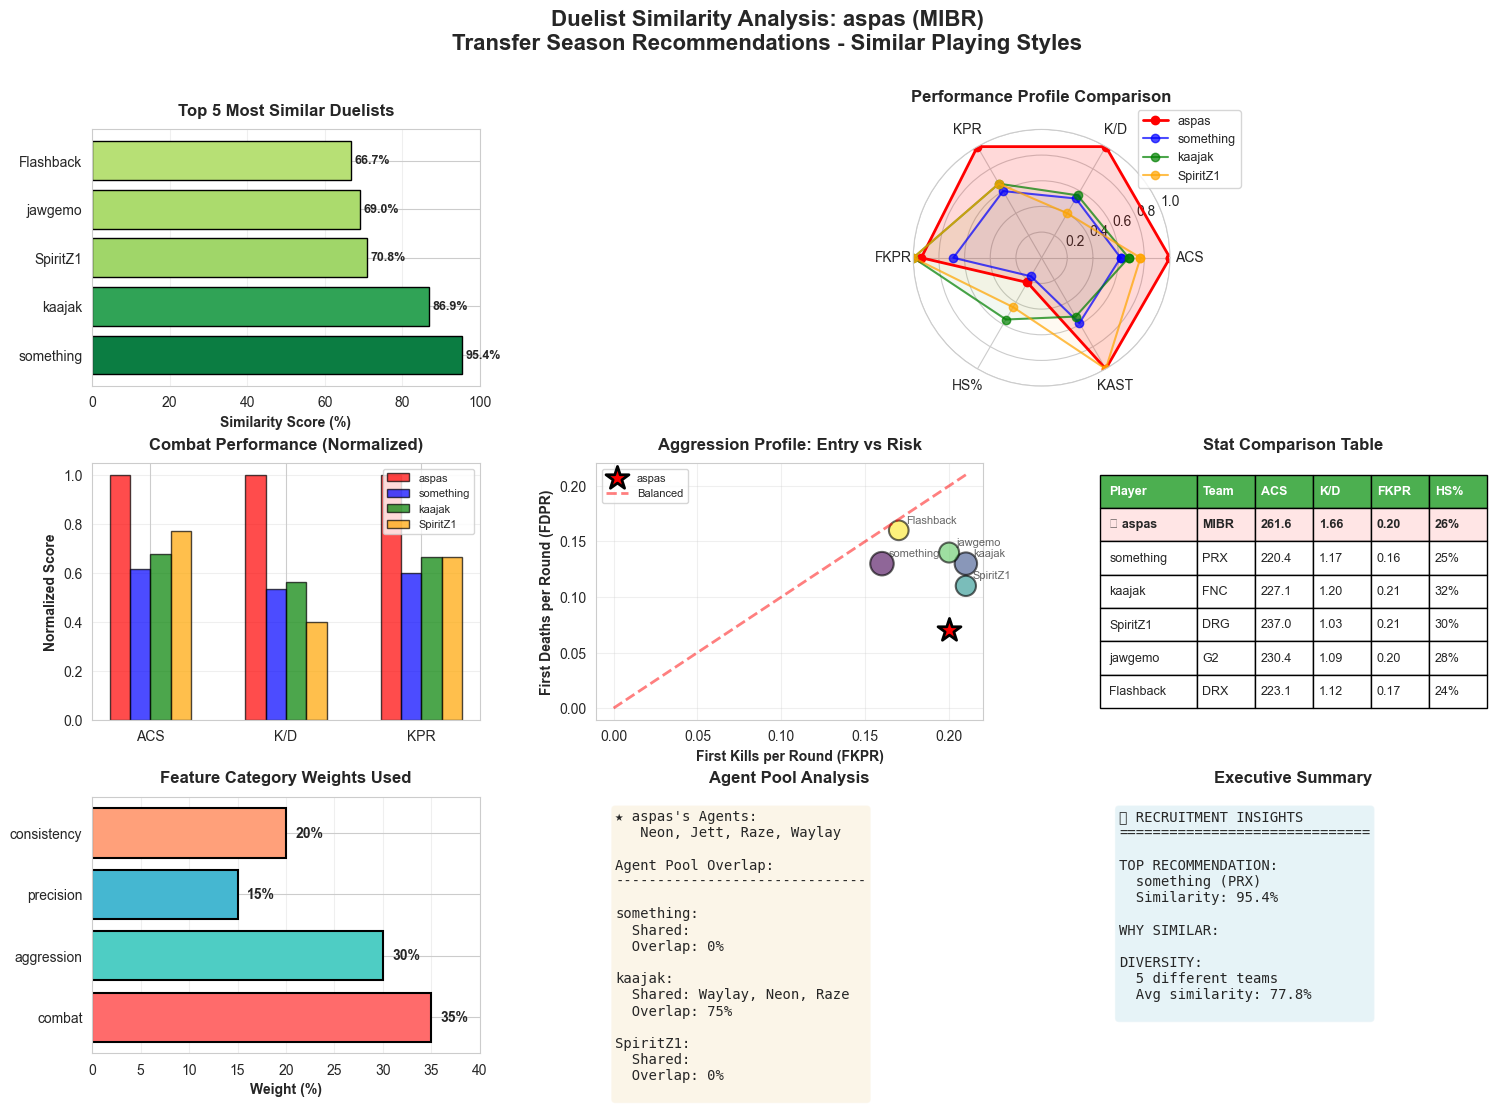

In [15]:
test_player = "aspas"

recommendations = recommend_similar_duelists(test_player, top_n=5, exclude_same_team=True)

print(f"\n Top 5 Similar Duelists (excluding {duelists[duelists['player_name']==test_player]['team'].values[0]} teammates):\n")

print(recommendations[['player_name', 'team', 'similarity', 'acs', 'kd_ratio', 'fkpr']].to_string(index=False))

# Generate visualization
print("\n  comprehensive comparison visualization...")
fig = visualize_comparison(test_player, recommendations)
plt.show()


 Top 5 Similar Duelists (excluding SEN teammates):

player_name team  similarity   acs  kd_ratio  fkpr
       mada  NRG   65.594232 214.2      1.06  0.17
  Flashback  DRX   59.836764 223.1      1.12  0.17
     ZmjjKK  EDG   54.239676 237.4      1.08  0.21
    jawgemo   G2   47.155975 230.4      1.09  0.20
    MiniBoo   TH   39.124294 204.4      0.95  0.19

  comprehensive comparison visualization...

✓ Saved visualization: recommendation_zekken.png


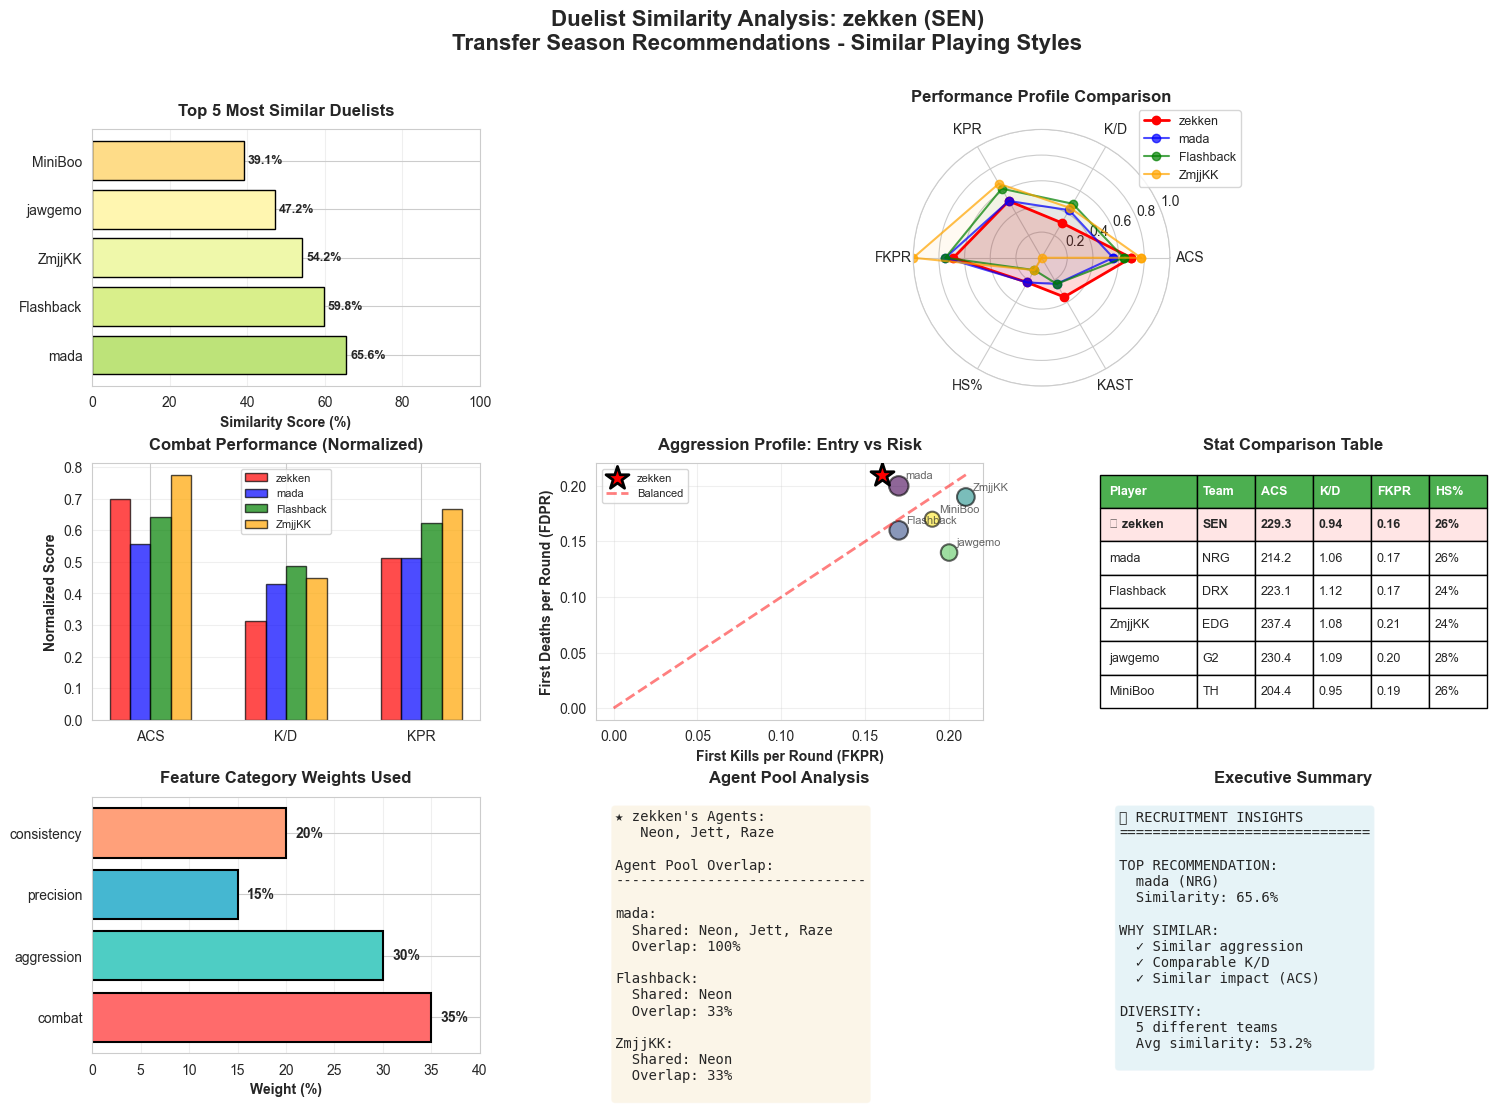

In [16]:
test_player = "zekken"

recommendations = recommend_similar_duelists(test_player, top_n=5, exclude_same_team=True)

print(f"\n Top 5 Similar Duelists (excluding {duelists[duelists['player_name']==test_player]['team'].values[0]} teammates):\n")

print(recommendations[['player_name', 'team', 'similarity', 'acs', 'kd_ratio', 'fkpr']].to_string(index=False))

# Generate visualization
print("\n  comprehensive comparison visualization...")
fig = visualize_comparison(test_player, recommendations)
plt.show()


 Top 5 Similar Duelists (excluding NRG teammates):

player_name team  similarity   acs  kd_ratio  fkpr
     ZmjjKK  EDG   68.385159 237.4      1.08  0.21
     zekken  SEN   65.594232 229.3      0.94  0.16
       kamo   TL   61.358616 190.3      0.94  0.14
  Flashback  DRX   60.125837 223.1      1.12  0.17
    MiniBoo   TH   59.414297 204.4      0.95  0.19

  comprehensive comparison visualization...

✓ Saved visualization: recommendation_mada.png


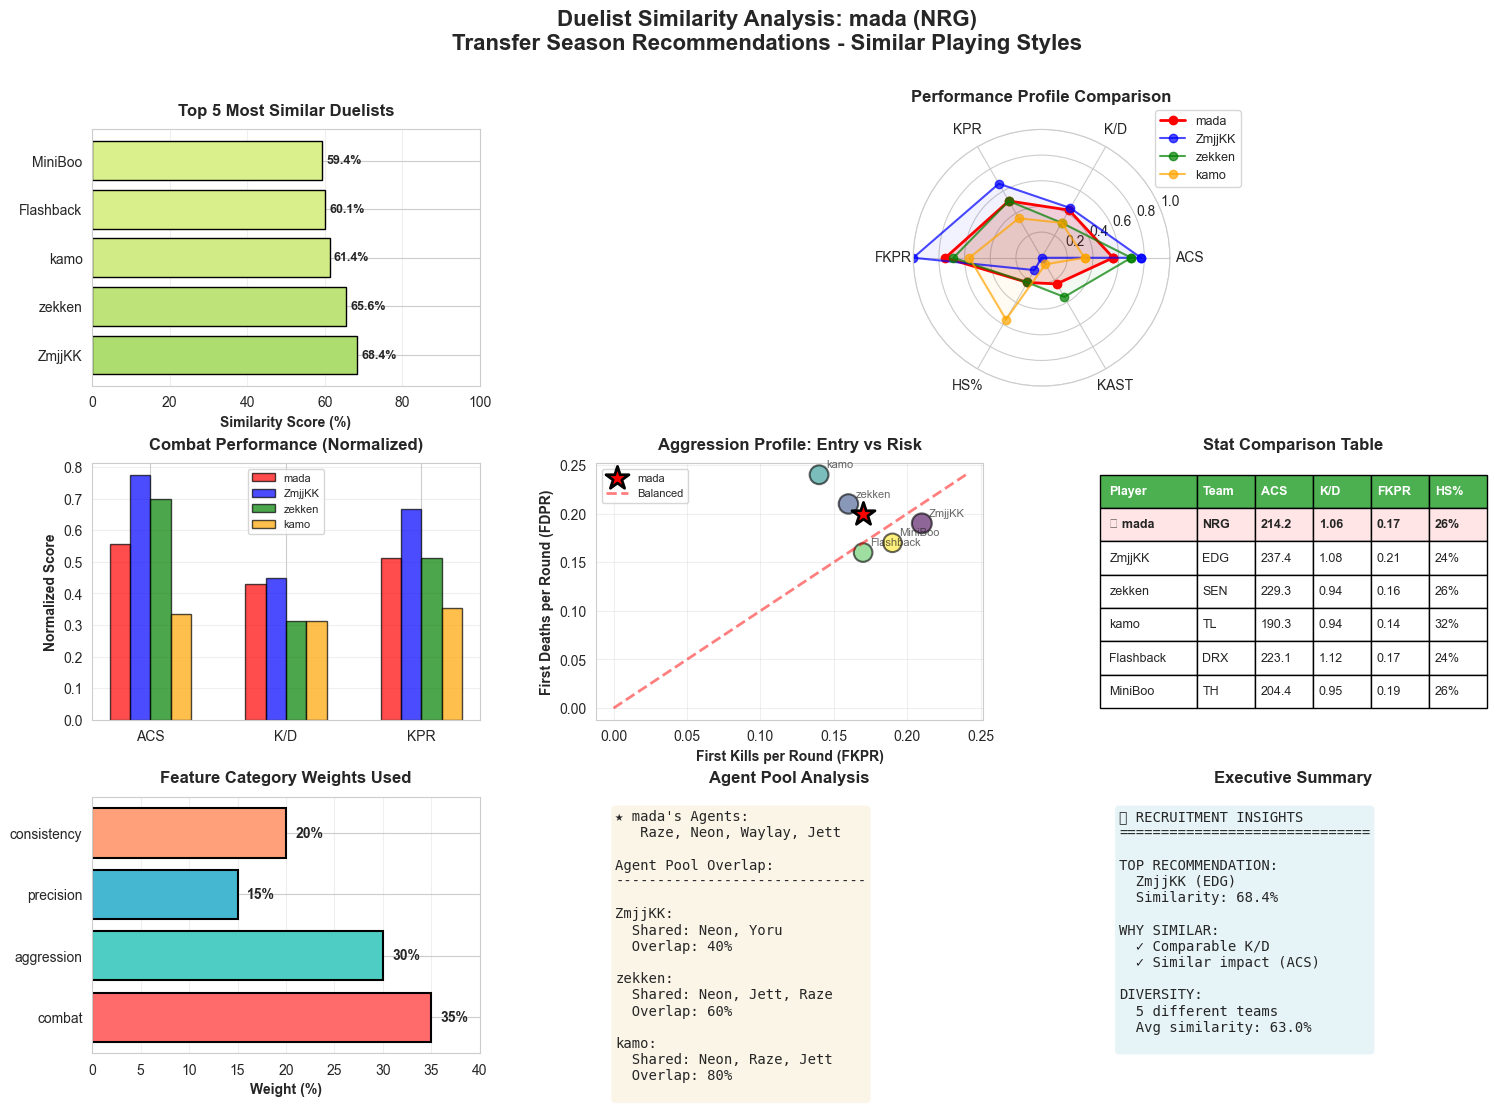

In [17]:
test_player = "mada"

recommendations = recommend_similar_duelists(test_player, top_n=5, exclude_same_team=True)

print(f"\n Top 5 Similar Duelists (excluding {duelists[duelists['player_name']==test_player]['team'].values[0]} teammates):\n")

print(recommendations[['player_name', 'team', 'similarity', 'acs', 'kd_ratio', 'fkpr']].to_string(index=False))

# Generate visualization
print("\n  comprehensive comparison visualization...")
fig = visualize_comparison(test_player, recommendations)
plt.show()


 Top 5 Similar Duelists (excluding TH teammates):

player_name team  similarity   acs  kd_ratio  fkpr
        ara   GX   77.248047 198.7      1.01  0.18
     Akeman  DRG   67.163575 196.8      0.88  0.15
       mada  NRG   59.414297 214.2      1.06  0.17
       kamo   TL   58.029319 190.3      0.94  0.14
     zekken  SEN   39.124294 229.3      0.94  0.16

  comprehensive comparison visualization...

✓ Saved visualization: recommendation_MiniBoo.png


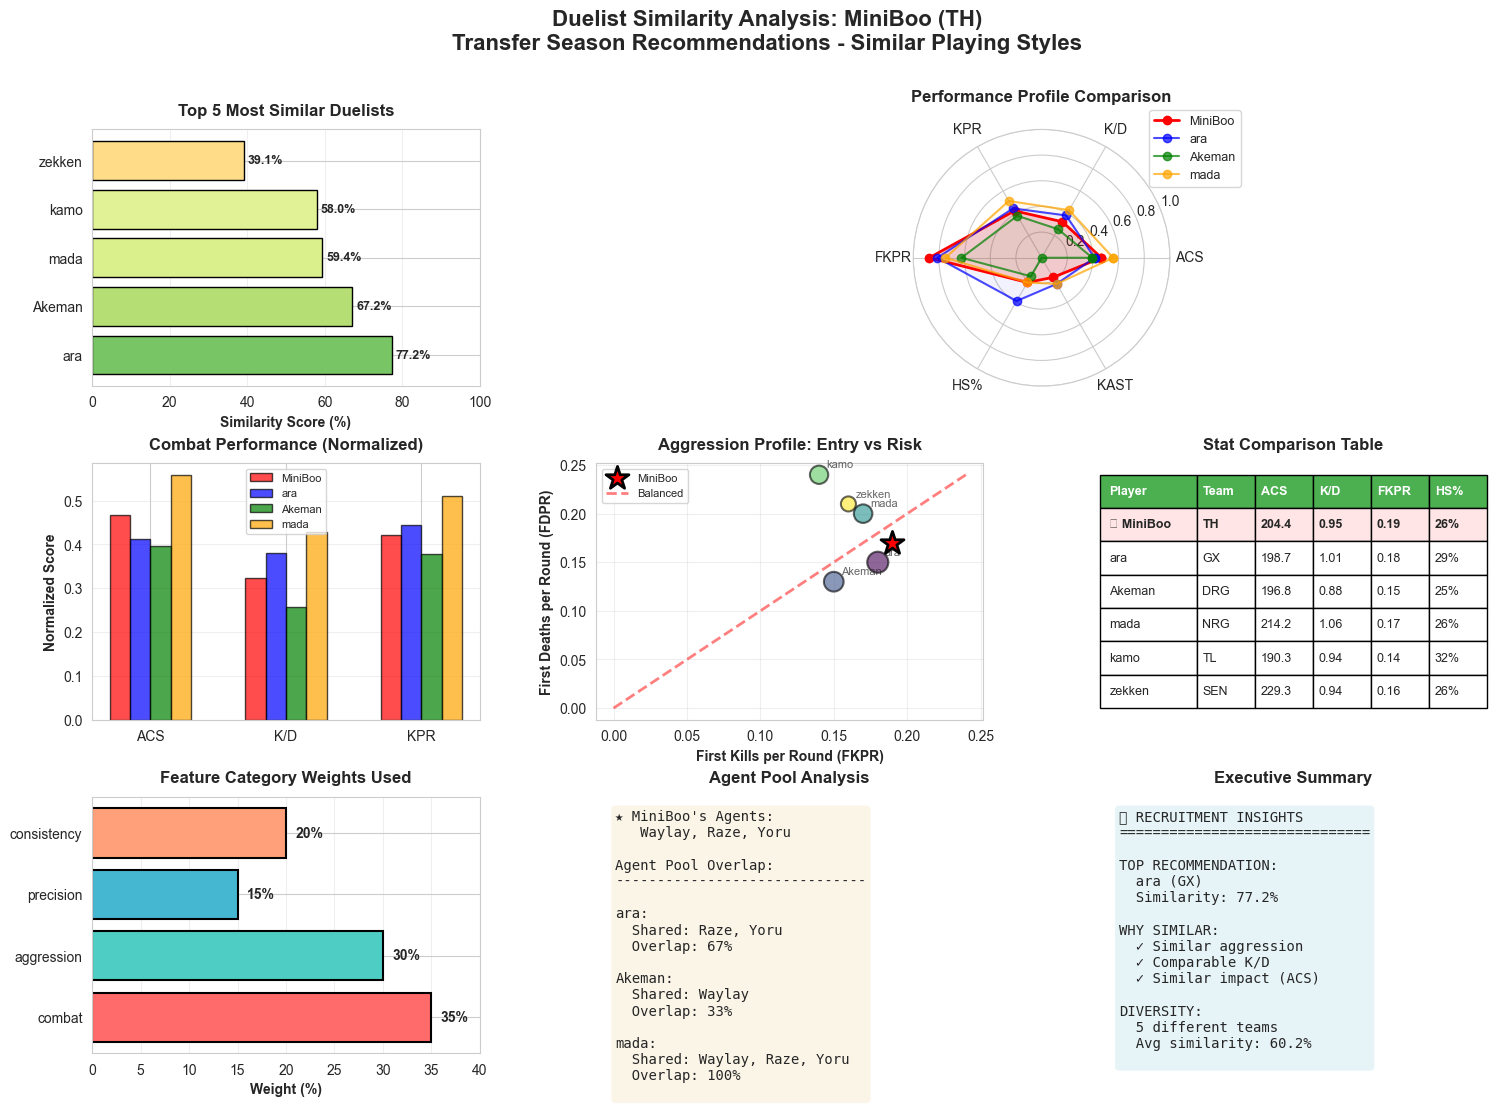

In [18]:
test_player = "MiniBoo"

recommendations = recommend_similar_duelists(test_player, top_n=5, exclude_same_team=True)

print(f"\n Top 5 Similar Duelists (excluding {duelists[duelists['player_name']==test_player]['team'].values[0]} teammates):\n")

print(recommendations[['player_name', 'team', 'similarity', 'acs', 'kd_ratio', 'fkpr']].to_string(index=False))

# Generate visualization
print("\n  comprehensive comparison visualization...")
fig = visualize_comparison(test_player, recommendations)
plt.show()